# Spam Classification

The objective of it is to generate a model capable to classify a email as spam or not spam.

The dataset used was from http://www2.aueb.gr/users/ion/data/enron-spam/

## Imports

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text as txt
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import email
from email.message import EmailMessage
from email.parser import BytesParser, Parser
from email.policy import default
import ast
import re
import datetime

[nltk_data] Downloading package stopwords to /home/phrc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/phrc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In [2]:
def createDf(path):
    """
    Read all email files and convert to a dataframe

    Parameters
    ----------
    path: str
        Path to a root directory to be read

    Returns
    ----------
    dataframe
        a dataframe with x columns based in all emails properties
    """
    os.chdir(path)
    data = []
    for root, dirs, files in os.walk(path):
         for file in files:
            with open(os.path.join(root, file), "rb") as openFile:
                dictTemp = {}
                try:
                    message = email.message_from_binary_file(openFile, policy=default)
                    #Parser(policy=default).parsestr(openFile.read())
                    dictTemp['file'] = openFile.name
                    for key in message.keys():
                        dictTemp[key.lower()] = message[key]
                    dictTemp['messageType'] = message.get_content_type()
                    body = message.get_body()
                    if body['content-type'].maintype == 'text':
                        if body['content-type'].subtype == 'plain':
                            dictTemp['messageStr'] = str(body.get_content())
                        elif body['content-type'].subtype == 'html':
                            dictTemp['messageStr'] = str(body)
                    elif body['content-type'].content_type in 'multipart':
                        dictTemp['messageStr'] = str(body.get_body(preferencelist=('html')))
                    dictTemp['parseError'] = False                 
                except:
                    dictTemp['parseError'] = True
                data.append(dictTemp)
    df = pd.DataFrame(data)
    return df

def emailTextCleanner(text):
    """
    Remove:
        Html Tags
        Email headers
        Ponctuation
        break lines and tabs
    
    And convert the string to lower case 

    Parameters
    ----------
    text: str

    Returns
    ----------
    str
    """
    try:
        text = str(text).lower()
        text = text.replace("\\", " ")
        text = text.replace("\x01", " ")
        clean = re.compile('charset.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('content-.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('received: from.*\n')
        text = re.sub(clean, '', text)
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', str(text))
        clean = re.compile('['+string.punctuation+']')
        text = re.sub(clean, ' ', text)
        clean = re.compile("[0-9]")
        text = re.sub(clean, " ", text)
        toRemove = frozenset(['xpriority','nbsp', 'enron','xmsmailpriority','xmimeole','mimeole','cc','enrons'])
        pattern = re.compile(r'\b(' + r'|'.join(toRemove) + r')\b\s*')
        text = pattern.sub(' ', text)
 
        return text
    except:
        print(type(text))
        return ""
    #text = TextBlob(text)
    #text = str(text.correct())
    
def lemmatizeList(words):
    """
    Lemmatize a list of string

    Parameters
    ----------
    words: list of str

    Returns
    ----------
    list of str
    """
    lem = WordNetLemmatizer()
    for i in range(len(words)):
        words[i] = lem.lemmatize(words[i], 'v')
        words[i] = lem.lemmatize(words[i], 'n')
    return words

def revomeWordsWithOneCharacter(words):
    return list(filter(lambda x : len(x) > 1, words))

def removeDigits(words):
    return list(filter(lambda x : x.isdigit() == False, words))

## Dataset generation

In [3]:
root = '/home/phrc/Python Project/Spam Email Classifier/'
#root = '/Users/phrc/Documents/Projects/pythonProject/SpamEmailClassifier/'

spamPath = root+'emails/spam/'
hamPath = root+'emails/ham/'


dfSpam = createDf(spamPath)
dfHam = createDf(hamPath)

## Dataset Size

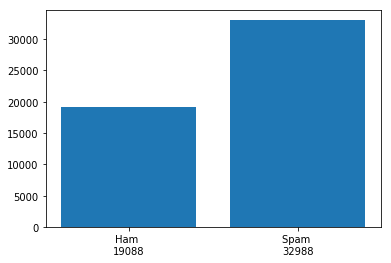

In [4]:

plt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
plt.xticks(np.arange(2), ('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))

plt.show();

### Dataset Spam Columns Analyse

In [5]:
dfSpamDesc = dfSpam.describe(include=['object']).T
print('Total of Spam attributes {}'.format(len(dfSpamDesc)))
n = len(dfSpam) * 0.75 
dfSpamDesc[dfSpamDesc['count'] > n].head(300)

Total of Spam attributes 465


,count,unique,top,freq
content-type,32835,7616,"text/html; charset=""iso-8859-7""",12553
date,32572,30490,"Tue, 19 Jan 2038 11:14:07 +0800",52
file,32988,32988,/home/phrc/Python Project/Spam Email Classifie...,1
from,32957,27895,COMPUTRON <khatun@emirates.net.ae>,347
messageStr,29849,27602,Call out Gouranga be happy!!!\nGouranga Gouran...,79
messageType,32965,8,text/html,16715
mime-version,31915,448,1.0,30943
subject,32831,20625,,613
to,32380,5254,paliourg@iit.demokritos.gr,7068


### Dataset Ham Columns Analyse

In [6]:
dfHamDesc = dfHam.describe(include=['object']).T
print('Total of Ham attributes {}'.format(len(dfHamDesc)))
n = len(dfHam) * 0.75 
dfHamDesc[dfHamDesc['count']> n].head(300)

Total of Ham attributes 19


,count,unique,top,freq
content-transfer-encoding,19079,2,7bit,18363
content-type,19079,2,"text/plain; charset=""us-ascii""",17818
date,19088,18173,"Wed, 13 Dec 2000 04:41:00 -0800",5
file,19088,19088,/home/phrc/Python Project/Spam Email Classifie...,1
from,19088,2349,pete.davis@enron.com,1395
message-id,19088,19088,<6413943.1075855894925.JavaMail.evans@thyme>,1
messageStr,19079,18401,\n\nTammie Schoppe\nEnron Americas-Office of ...,5
messageType,19079,1,text/plain,19079
mime-version,19079,1,1.0,19079
subject,19084,14679,Schedule Crawler: HourAhead Failure,343


### Removing unnescessary columns

In [7]:
dfSpam = dfSpam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to', 'parseError']]
dfHam = dfHam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to', 'parseError']]


### Emails with Parser Error 

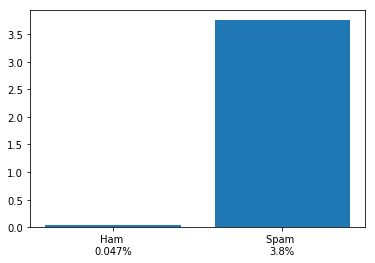

In [8]:
dfHamP = dfHam[dfHam['parseError'] == True]
dfSpamP = dfSpam[dfSpam['parseError'] == True]
hamFreq = (len(dfHamP) * 100 / len(dfHam))
spamFreq = (len(dfSpamP) * 100 / len(dfSpam))
plt.bar(np.arange(2), (hamFreq, spamFreq), align='center')
plt.xticks(np.arange(2), ('Ham \n{0:.2}%'.format(hamFreq), 'Spam \n{0:.2}%'.format(spamFreq)))

plt.show();

### Removing emails with parser problems 

In [9]:
dfSpam = dfSpam[dfSpam['parseError'] == False]
dfHam = dfHam[dfHam['parseError'] == False]

del dfHam['parseError']
del dfSpam['parseError']

### Join datasets

In [10]:
dfSpam['isSpam'] = True
dfHam['isSpam'] = False

dfMaster = pd.concat([dfSpam, dfHam])
print('Total size of dataset {}'.format(len(dfMaster)))
dfMaster.head()

Total size of dataset 50828


,date,from,messageStr,messageType,subject,to,isSpam
0,"Fri, 24 Jun 2005 23:29:50 +0600",Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,True
1,"Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,True
3,"Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,True
4,"Sun, 03 Jul 2005 21:45:26 +0000",Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,True
5,"Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,True


### Check email message and email type 

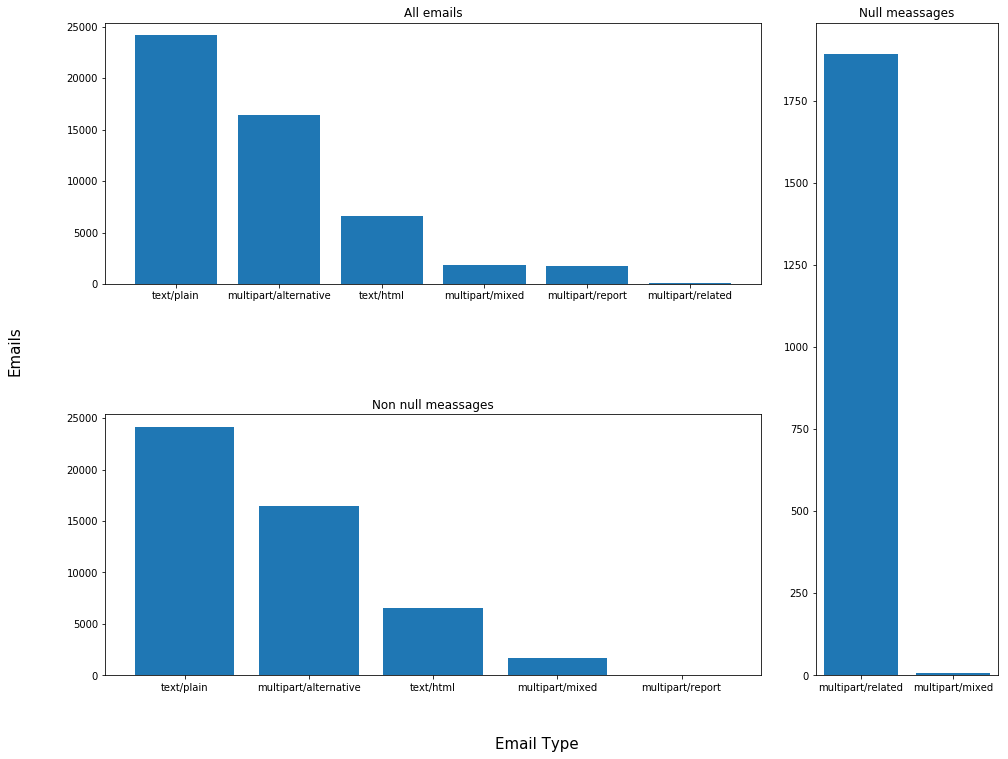

In [11]:
fig = plt.figure(figsize = (16,12))
grid = plt.GridSpec(2,4, wspace =0.3, hspace =0.5)
barAll = fig.add_subplot(grid[0,0:3])
barNonNull = fig.add_subplot(grid[1,0:3])
barNull = fig.add_subplot(grid[0:2,3])

barAll.bar(
    dfMaster['messageType'].unique(), 
    dfMaster['messageType'].value_counts(), 
    align='center'
)
barAll.set_title('All emails')

barNonNull.bar(
    dfMaster[dfMaster['messageStr'].notnull()]['messageType'].unique(), 
    dfMaster[dfMaster['messageStr'].notnull()]['messageType'].value_counts(), 
    align='center'
)

barNonNull.set_title('Non null meassages')

barNull.bar(
    dfMaster[dfMaster['messageStr'].isnull()]['messageType'].unique(), 
    dfMaster[dfMaster['messageStr'].isnull()]['messageType'].value_counts(), 
    align='center'
)

barNull.set_title('Null meassages')

fig.text(0.5, 0.04, 'Email Type', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Emails', va='center', rotation='vertical', fontsize=15)

plt.show()

### Null messages proportions

([<matplotlib.patches.Wedge at 0x7fa2b78fe2e8>,
 [Text(-1.1917347975584003, 0.1405993324608573, 'Non Null'),
  Text(1.1917347876855027, -0.14059941614455557, 'Null')],
 [Text(-0.49655616564933347, 0.05858305519202387, '96%'),
  Text(0.4965561615356261, -0.05858309006023149, '4%')])

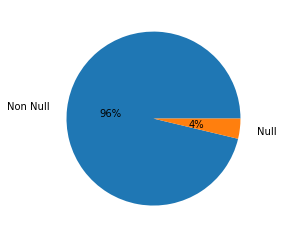

In [12]:
plt.pie([len(dfMaster[dfMaster['messageStr'].notnull()]), len(dfMaster[dfMaster['messageStr'].isnull()])], 
        labels=['Non Null', 'Null'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


### Remove null messages 

In [13]:
dfMaster = dfMaster[dfMaster['messageStr'].notnull()]

print('Total size of dataset: {}'.format(len(dfMaster[dfMaster['messageStr'].notnull()])))

Total size of dataset: 48928


# - - - - - - - CLEANING Remove HTML tags from the messages 

## Preparing the dataset

In [14]:
#Apply cleaning method
dfMaster['treatedMessage'] = dfMaster['messageStr'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Create a column with list of words
dfMaster['wordsList'] = dfMaster['treatedMessage'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedWords'] = dfMaster['wordsList'].apply(lambda x : len(x))
dfMaster['treatedTextLen'] = dfMaster['treatedMessage'].apply(lambda x : len(x))
dfMaster['textLen'] = dfMaster['messageStr'].apply(lambda x : len(str(x)))
dfMaster['uniqueWordsLen'] = dfMaster['wordsList'].apply(lambda x : len(set(x)))


#Convert Date to a date time object
dfMaster['date'] = dfMaster['date'].apply(lambda x : str(x)).apply(lambda x : None if x == 'nan' else datetime.datetime.strptime(x, '%a, %d %b %Y %H:%M:%S %z'))

#Create a Hour Column
dfMaster['hour'] = dfMaster['date'].apply(lambda x : None if x == None else x.hour)

#Create a count to
dfMaster['toCount'] = dfMaster['to'].str.split(',').apply(lambda x : len(x) if isinstance(x, list) else 0)

dfMaster.head()

,date,from,messageStr,messageType,subject,to,isSpam,treatedMessage,wordsList,totalTreatedWords,treatedTextLen,textLen,uniqueWordsLen,hour,toCount
0,2005-06-24 23:29:50+06:00,Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,True,girlfriend really enjoying making homemade ero...,"[girlfriend, really, enjoy, make, homemade, er...",139,957,1605,97,23.0,1
1,2005-06-24 06:36:39-05:00,GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,True,gotomeeting generation online meetings arrived...,"[gotomeeting, generation, online, meet, arrive...",93,759,4171,65,6.0,1
3,2005-07-13 09:06:59-04:00,Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,True,hq management bank account open new need excel...,"[hq, management, bank, account, open, new, nee...",71,553,1582,66,9.0,1
4,2005-07-03 21:45:26+00:00,Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,True,projecthoneypotmailserver smtp jul squirrelmai...,"[projecthoneypotmailserver, smtp, jul, squirre...",71,510,1338,60,21.0,1
5,2005-06-22 05:57:20-05:00,Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,True,,[],0,0,2,0,5.0,1


## Visualisation

### Dataset distribution by spam type

#### Size

Spam    29849
Ham     19079
Name: isSpam, dtype: int64


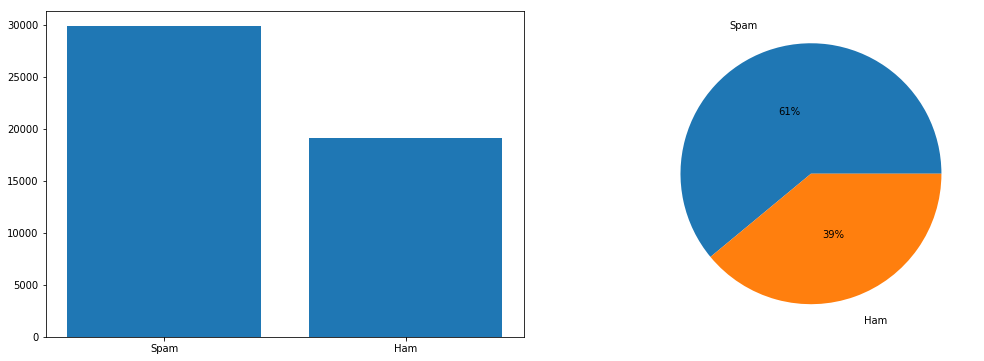

In [15]:
df = dfMaster

print(df['isSpam'].value_counts().rename({False: 'Ham', True: 'Spam'}))


fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])


barPlt.bar(
    ('Spam', 'Ham'), 
    [len(df[df['isSpam'] == True]), len(df[df['isSpam'] == False])], 
    align='center')
barPlt.set_xticks(np.arange(2), ['Spam', 'Ham'])


piePlt.pie(df['isSpam'].value_counts(), labels=['Spam', 'Ham'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

#### Message Type

messageType            isSpam
multipart/alternative  True       6564
multipart/mixed        True       1709
multipart/report       True         70
text/html              True      16431
text/plain             False     19079
                       True       5075
dtype: int64


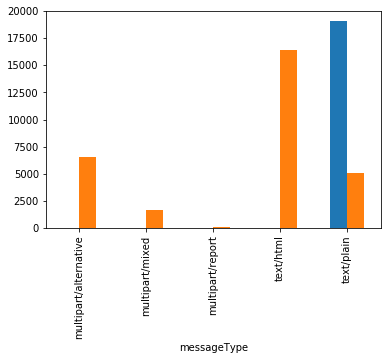

In [16]:
dfGroup = df.groupby(['messageType', 'isSpam']).size()
print(dfGroup)
dfGroup.unstack().plot(kind='bar', legend=False)

### Day Hour

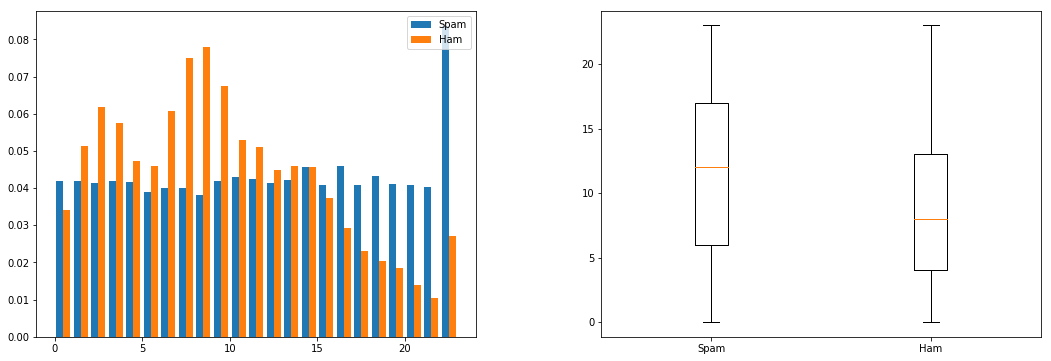

In [17]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2:4])

histPlt.hist(
    [
        df[df['isSpam'] == True]['hour'].dropna(), 
        df[df['isSpam'] == False]['hour']
    ], 
    np.linspace(0, df['hour'].max(), 24), 
    density = True, 
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['hour'].dropna(),
        df[df['isSpam'] == False]['hour']
    ), 
    labels = ('Spam', 'Ham')
)


plt.show()

### To

In [18]:
df['toCount'].describe()

count    48928.000000
mean         3.165284
std         13.404586
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        595.000000
Name: toCount, dtype: float64

In [19]:
df[df['toCount'] > 1]['toCount'].describe()

count    8038.000000
mean       14.333167
std        30.731960
min         2.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       595.000000
Name: toCount, dtype: float64

In [39]:
df[df['toCount'] > 15]['toCount'].describe()

count    1589.00000
mean       51.25236
std        55.06003
min        16.00000
25%        21.00000
50%        32.00000
75%        60.00000
max       595.00000
Name: toCount, dtype: float64

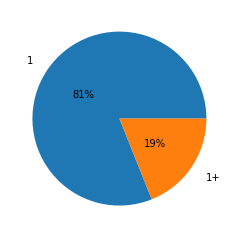

In [90]:
df['toCountG2'] = df['toCount'].apply(lambda x : '1' if x == 1 else '1+')

plt.pie(df['toCountG2'].value_counts(), labels=['1', '1+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

plt.show()

toCountG2  isSpam
1          False     11703
           True      27958
1+         False      7376
           True       1891
dtype: int64


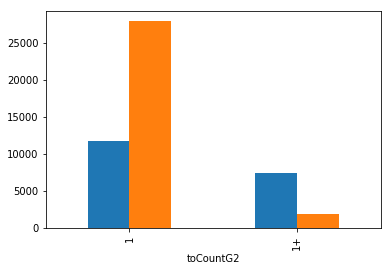

In [89]:
dfGroupTo = df.groupby(['toCountG2', 'isSpam']).size()
print(dfGroupTo)
dfGroupTo.unstack().plot(kind='bar', legend=False)

In [65]:
from sklearn import tree

df['isSpamStr'] = df['isSpam'].apply(lambda x: str(x))

clf = tree.DecisionTreeClassifier()
clf = clf.fit(df[['toCount']], df['isSpamStr'])

print(clf)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


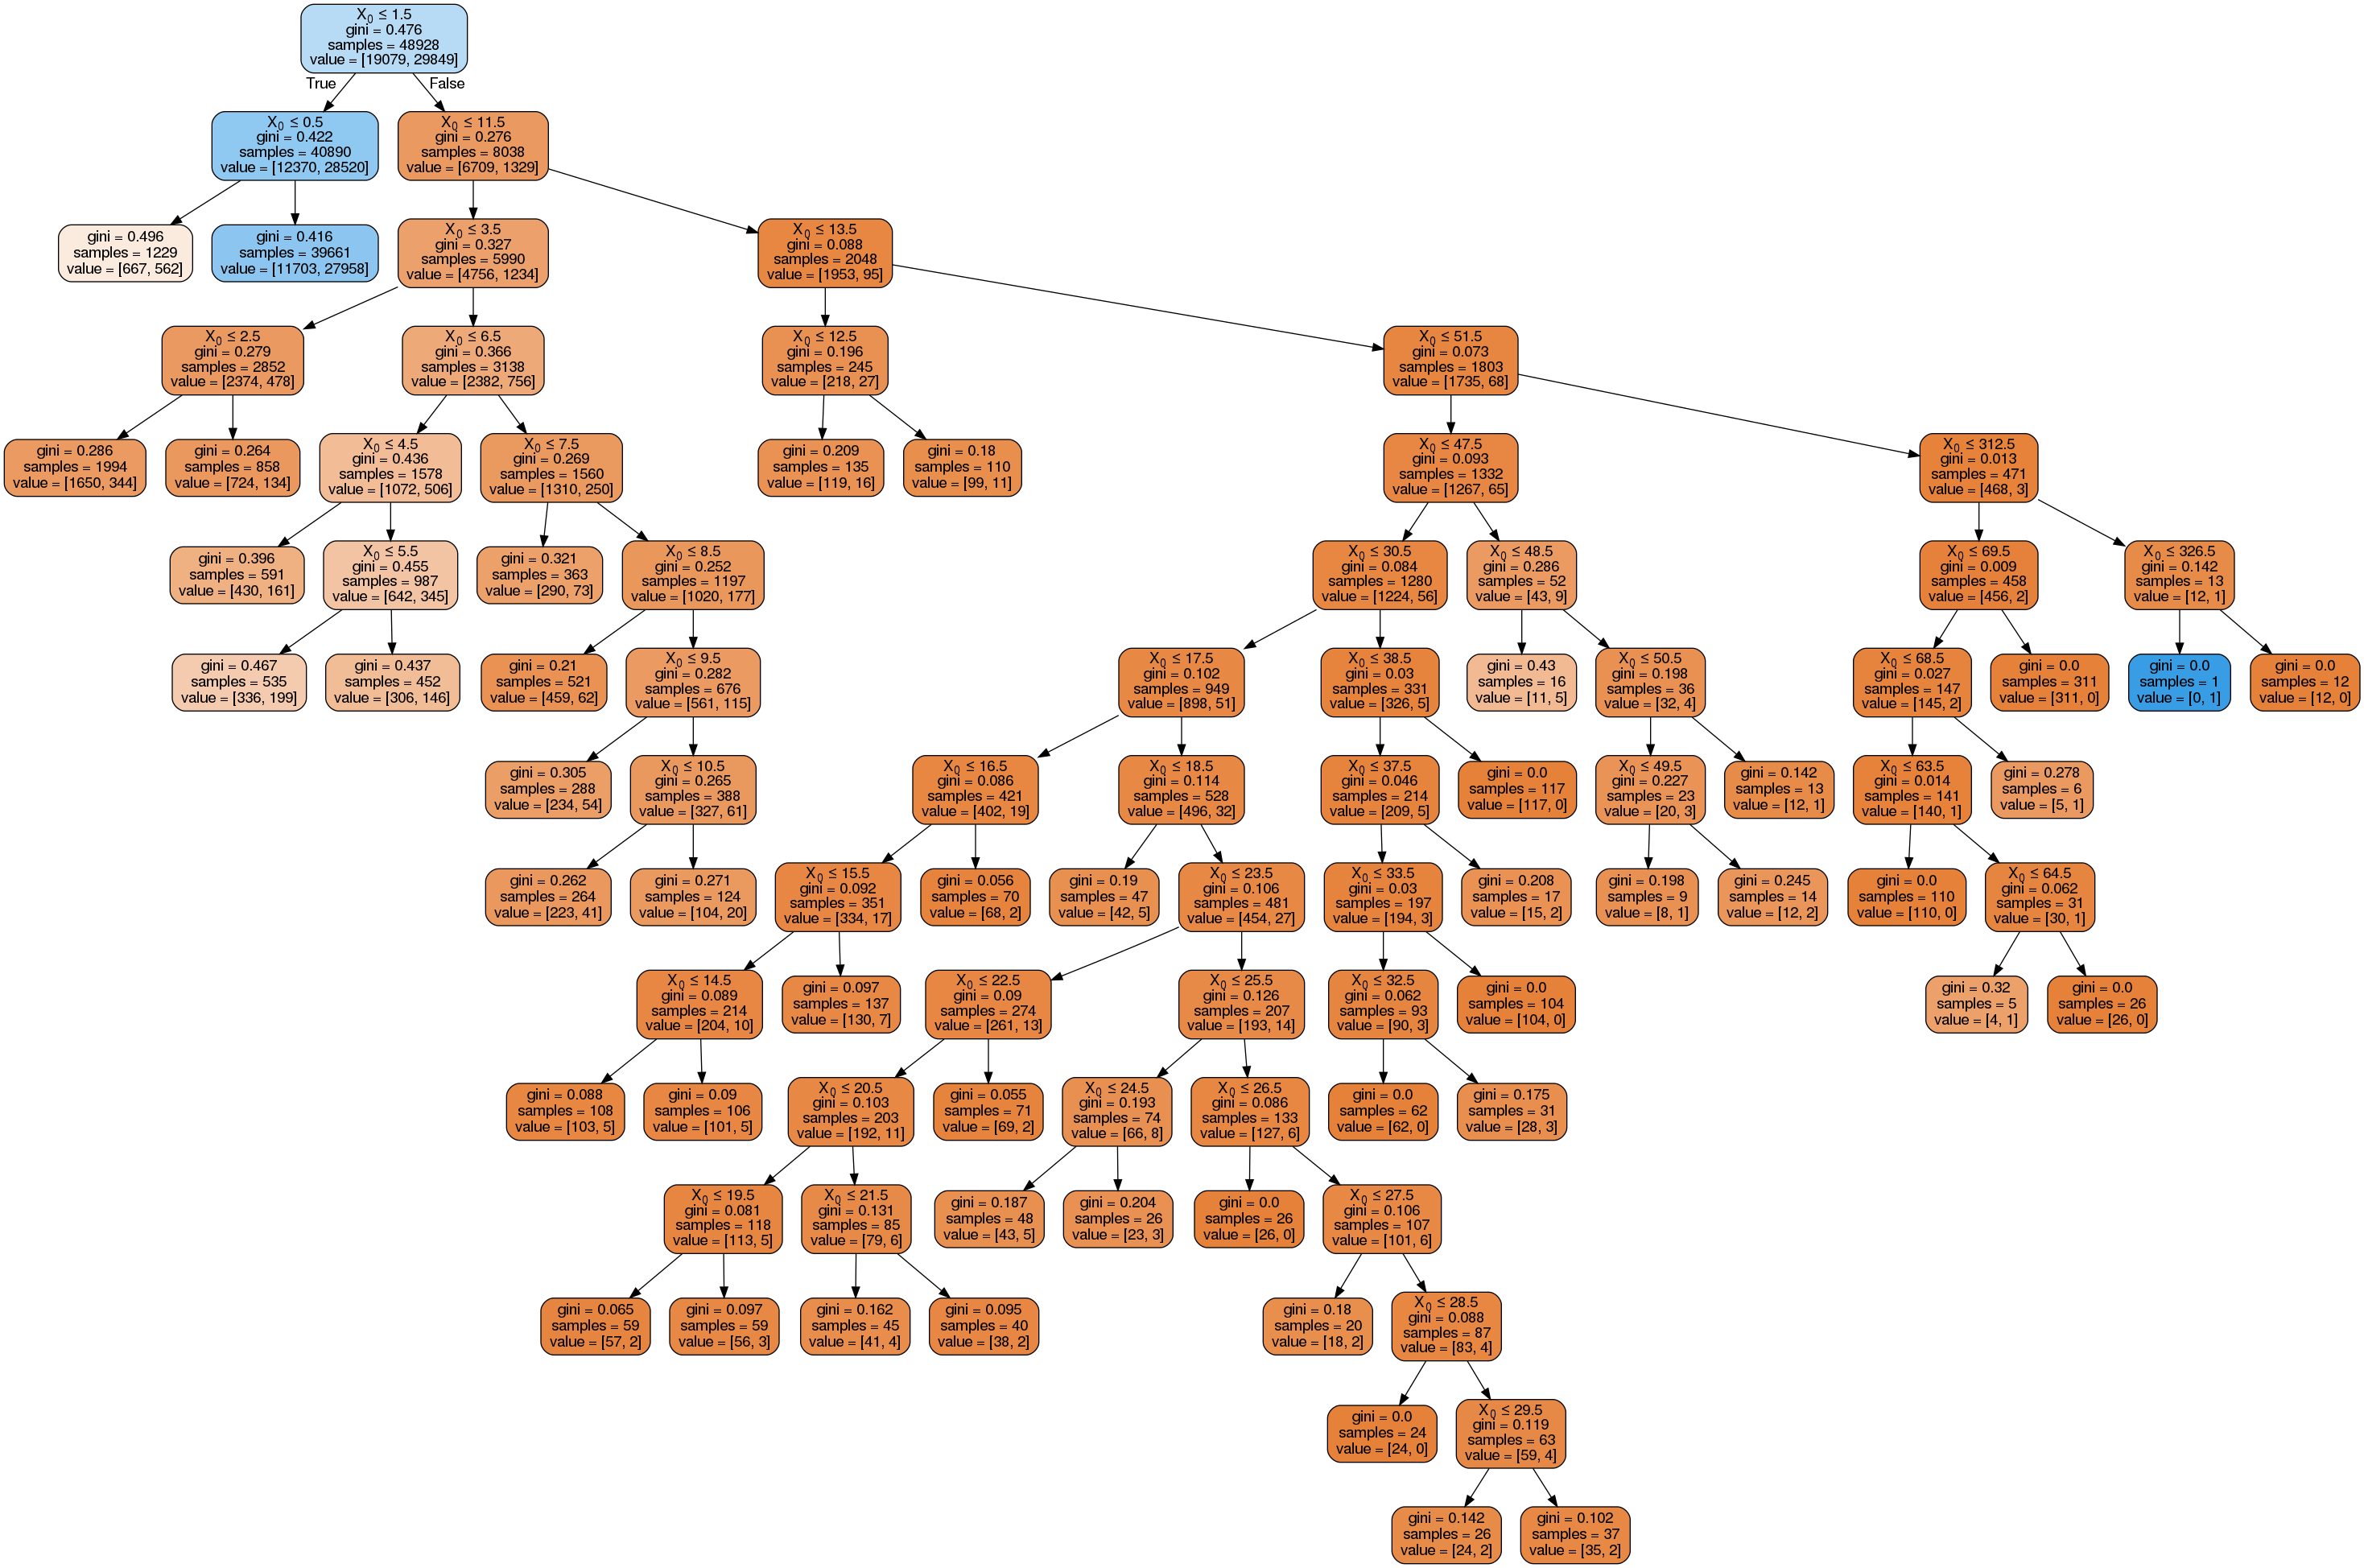

In [66]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())





In [20]:
dfMaster['toCountGroup'] = dfMaster['toCount'].apply(lambda x: 'direct' if x == 1 else ('smallGroup' if x < 15 else 'bigGroup'))  

dfMaster.head()

,date,from,messageStr,messageType,subject,to,isSpam,treatedMessage,wordsList,totalTreatedWords,treatedTextLen,textLen,uniqueWordsLen,hour,toCount,toCountGroup
0,2005-06-24 23:29:50+06:00,Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,True,girlfriend really enjoying making homemade ero...,"[girlfriend, really, enjoy, make, homemade, er...",139,957,1605,97,23.0,1,direct
1,2005-06-24 06:36:39-05:00,GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,True,gotomeeting generation online meetings arrived...,"[gotomeeting, generation, online, meet, arrive...",93,759,4171,65,6.0,1,direct
3,2005-07-13 09:06:59-04:00,Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,True,hq management bank account open new need excel...,"[hq, management, bank, account, open, new, nee...",71,553,1582,66,9.0,1,direct
4,2005-07-03 21:45:26+00:00,Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,True,projecthoneypotmailserver smtp jul squirrelmai...,"[projecthoneypotmailserver, smtp, jul, squirre...",71,510,1338,60,21.0,1,direct
5,2005-06-22 05:57:20-05:00,Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,True,,[],0,0,2,0,5.0,1,direct


toCountGroup  isSpam
bigGroup      False      1632
              True         63
direct        False     11703
              True      27958
smallGroup    False      5744
              True       1828
dtype: int64


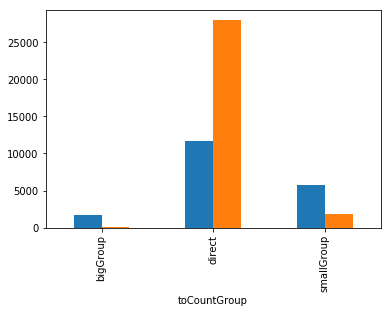

In [21]:
dfGroupTo = df.groupby(['toCountGroup', 'isSpam']).size()
print(dfGroupTo)
dfGroupTo.unstack().plot(kind='bar', legend=False)

In [72]:
bigF = 1632
bigT = 63
smallF = 5744
smallT = 1828

totalBig = bigF + bigT
totalSmall = smallF + smallT

rateBigF = bigF / totalBig
rateBigT = bigT / totalBig
rateSmallF = smallF / totalSmall
rateSmallT = smallT / totalSmall
print(rateBigF)
print(rateBigT)
print(rateSmallF)
print(rateSmallT)


0.9628318584070796
0.03716814159292035
0.7585842577918648
0.24141574220813525


### Compare text lenght for ham and spam  

There is 4 differents attributes what define the text lengh:

- textLen : This is the raw text without any treatment
- treatedTextLen: This is the text after removing the stop words and ponctuation
- totalTreatedWords: This is the amount of words used in the text after the treatment, basically this exclude space and line breaks
- uniqueWordsLen: This is the amount of unique words used in the treated text, basically it removes repited words

### Raw Text size lengh comparison  

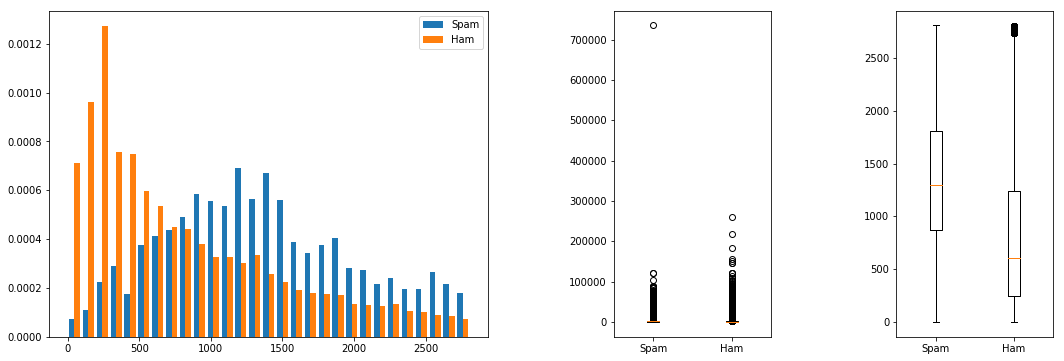

In [22]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['textLen'], 
        df[df['isSpam'] == False]['textLen']
    ], 
    np.linspace(0, df['textLen'].quantile(0.75), 30), 
    density = True, 
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
         df[df['isSpam'] == True]['textLen'], 
         df[df['isSpam'] == False]['textLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['textLen'] < df['textLen'].quantile(0.75))]['textLen'], 
        df[(df['isSpam'] == False) & (df['textLen'] < df['textLen'].quantile(0.75))]['textLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()

### Text size without stop words and punctuation 

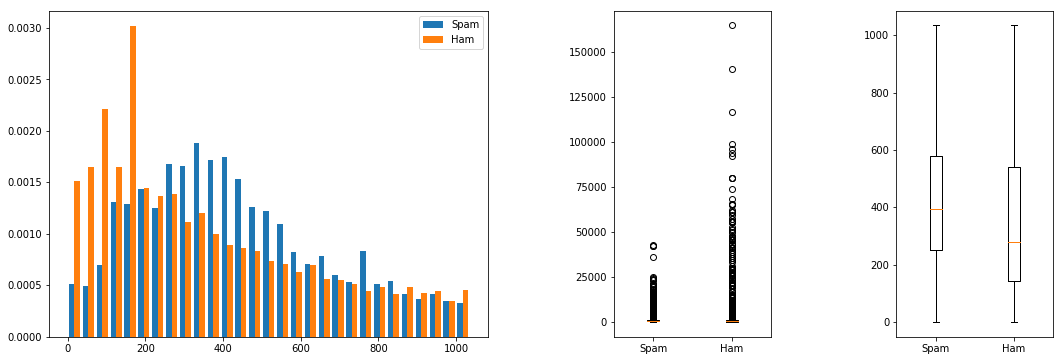

In [23]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['treatedTextLen'], 
        df[df['isSpam'] == False]['treatedTextLen']
    ],  
    np.linspace(0, df['treatedTextLen'].quantile(0.75), 30),
    density= True,
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['treatedTextLen'], 
        df[df['isSpam'] == False]['treatedTextLen'] ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['treatedTextLen'] < df['treatedTextLen'].quantile(0.75))]['treatedTextLen'], 
        df[(df['isSpam'] == False) & (df['treatedTextLen'] < df['treatedTextLen'].quantile(0.75))]['treatedTextLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()



### Total words used

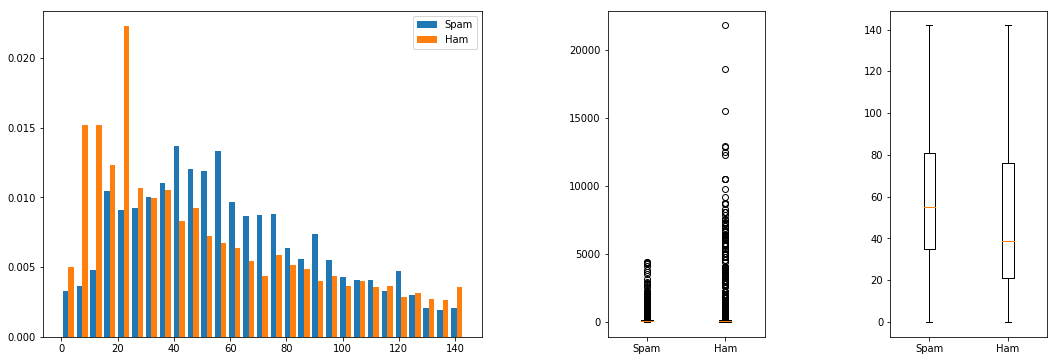

In [24]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['totalTreatedWords'], 
        df[df['isSpam'] == False]['totalTreatedWords']
    ],  
    np.linspace(0, df['totalTreatedWords'].quantile(0.75), 30),
    density= True,
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['totalTreatedWords'], 
        df[df['isSpam'] == False]['totalTreatedWords'] 
    ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['totalTreatedWords'] < df['totalTreatedWords'].quantile(0.75))]['totalTreatedWords'], 
        df[(df['isSpam'] == False) & (df['totalTreatedWords'] < df['totalTreatedWords'].quantile(0.75))]['totalTreatedWords'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()


### Total unique words used

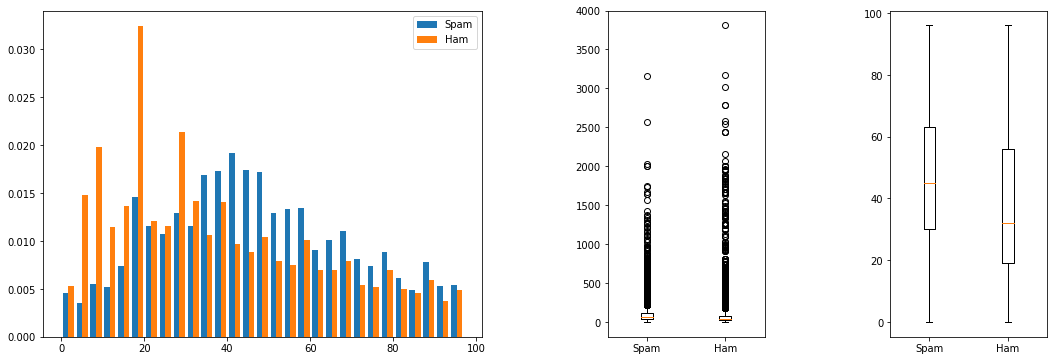

In [25]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['uniqueWordsLen'], 
        df[df['isSpam'] == False]['uniqueWordsLen']
    ],  
    np.linspace(0, df['uniqueWordsLen'].quantile(0.75), 30),
    density= True,
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['uniqueWordsLen'], 
        df[df['isSpam'] == False]['uniqueWordsLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['uniqueWordsLen'] < df['uniqueWordsLen'].quantile(0.75))]['uniqueWordsLen'], 
        df[(df['isSpam'] == False) & (df['uniqueWordsLen'] < df['uniqueWordsLen'].quantile(0.75))]['uniqueWordsLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()


### Conclusion

# Need to do 

----It's not clear the text size can influence into the classification of the email in spam or ham.



## Words Visualization

### Total uniques words

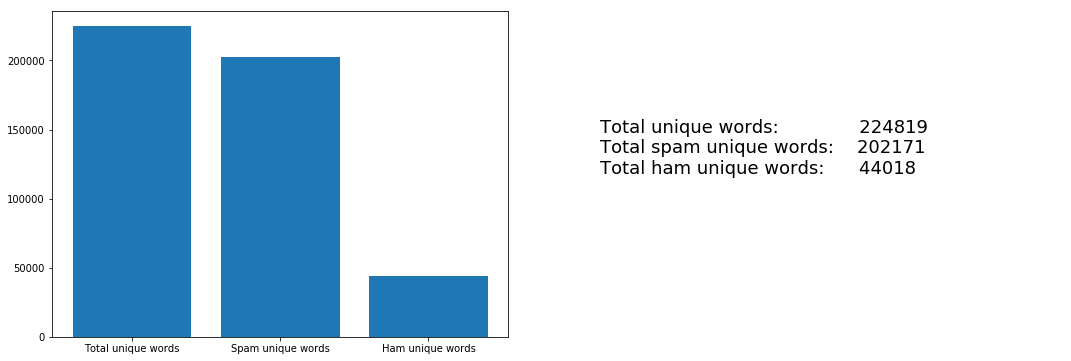

In [26]:
count = Counter(list(chain(*df["wordsList"].values)))

countSpam = Counter(list(chain(*df[df['isSpam'] == True]["wordsList"].values)))

countHam = Counter(list(chain(*df[df['isSpam'] == False]["wordsList"].values)))

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.2)
pltBar = fig.add_subplot(grid[0,0])
pltText = fig.add_subplot(grid[0,1])

pltBar.bar(
    ['Total unique words', 'Spam unique words', 'Ham unique words'], 
    [len(count), len(countSpam), len(countHam)], 
    align='center'
)

textWords = ['Total unique words:              {}'.format(len(count)), 
             'Total spam unique words:    {}'.format(len(countSpam)), 
             'Total ham unique words:      {}'.format(len(countHam))]



pltText.text(x=0, y=0.5, s = '\n'.join(textWords), fontsize = 18) 
pltText.axis('off')
plt.show()

### Total Unique words with more the 100 repetitions

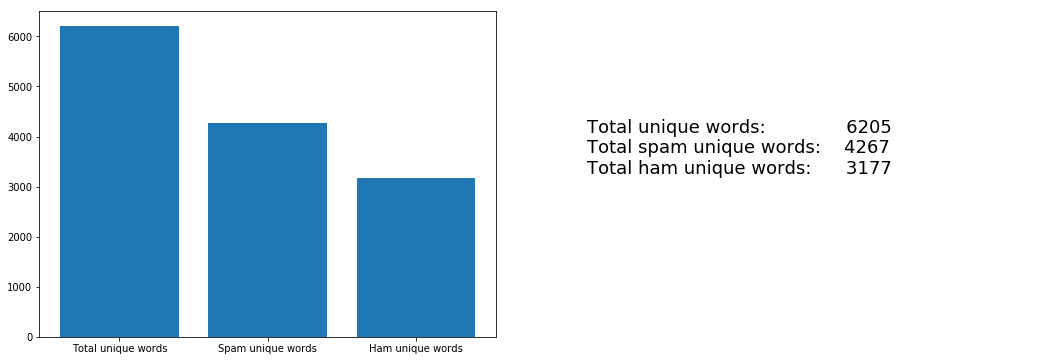

In [27]:
dfCounter = pd.DataFrame.from_dict(data = dict(count),orient='index', columns = ['freq'])

dfCounterSpam = pd.DataFrame.from_dict(data = dict(countSpam),orient='index', columns = ['freq'])

dfCounterHam = pd.DataFrame.from_dict(data = dict(countHam),orient='index', columns = ['freq'])

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.2)
pltBar = fig.add_subplot(grid[0,0])
pltText = fig.add_subplot(grid[0,1])

pltBar.bar(
    ['Total unique words', 'Spam unique words', 'Ham unique words'], 
    [len(dfCounter[dfCounter['freq'] > 100]), 
     len(dfCounterSpam[dfCounterSpam['freq'] > 100]), 
     len(dfCounterHam[dfCounterHam['freq'] > 100])], 
    align='center'
)

textWords = ['Total unique words:              {}'.format(len(dfCounter[dfCounter['freq'] > 100])), 
             'Total spam unique words:    {}'.format(len(dfCounterSpam[dfCounterSpam['freq'] > 100])), 
             'Total ham unique words:      {}'.format(len(dfCounterHam[dfCounterHam['freq'] > 100]))]



pltText.text(x=0, y=0.5, s = '\n'.join(textWords), fontsize = 18) 
pltText.axis('off')
plt.show()

### 20 Most common words

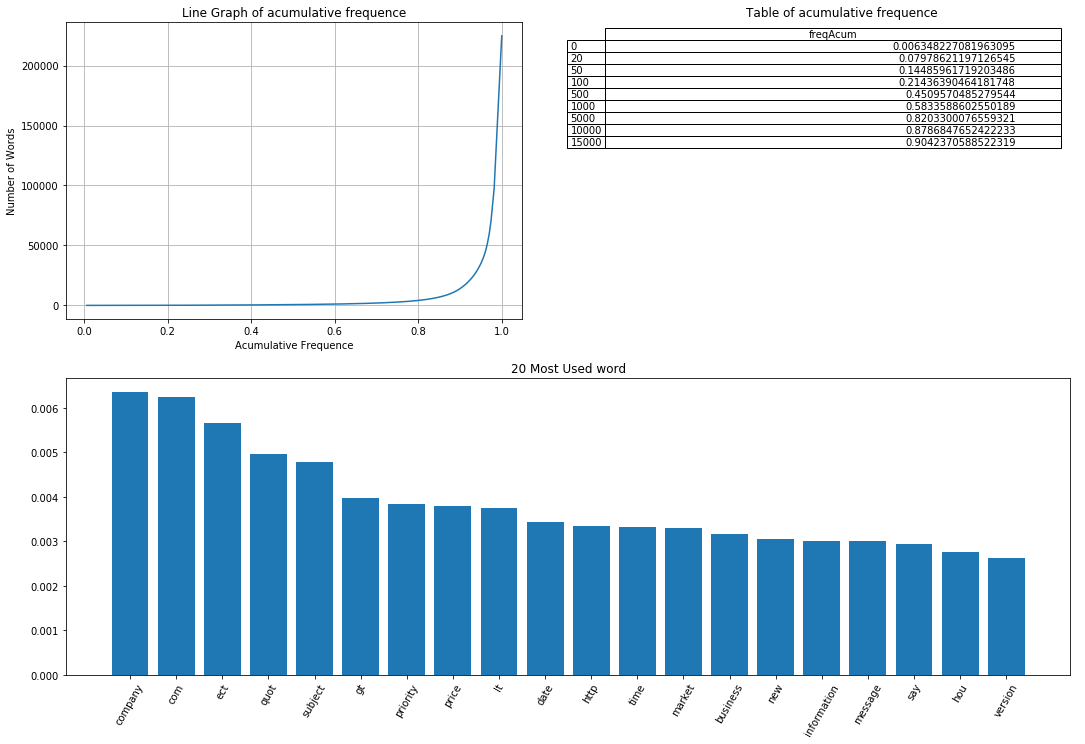

In [28]:
dfWords = pd.DataFrame(list(dict(count).items()))
dfWords.columns = ['word', 'occur'] 
totalOcurr = dfWords['occur'].sum()
dfWords['freq'] = dfWords['occur'] / totalOcurr  
dfWords = dfWords.sort_values(by='freq', ascending=False)
dfWords = dfWords.reset_index(drop=True)
dfWords['freqAcum'] = dfWords['freq'].cumsum()


fig = plt.figure(figsize = (18,12))
grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
pltLine = fig.add_subplot(grid[0:2,0])
pltBar = fig.add_subplot(grid[2:4,0:2])
pltTable = fig.add_subplot(grid[0:2,1])

pltLine.plot(dfWords['freqAcum'], range(len(dfWords)))
pltLine.set_ylabel('Number of Words')
pltLine.set_xlabel('Acumulative Frequence')
pltLine.set_title('Line Graph of acumulative frequence')
pltLine.grid(True)


dfTWord = dfWords.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTable.table(cellText=dfTWord.values, rowLabels= dfTWord.index, colLabels = dfTWord.columns, loc='best')
pltTable.axis('off')
pltTable.set_title('Table of acumulative frequence')



pltBar.bar(dfWords.head(20)['word'], dfWords.head(20)['freq'])
pltBar.set_title('20 Most Used word')

yPos = np.arange(20)
pltBar.set_xticklabels(dfWords.head(20)["word"], rotation=60)
pltBar.set_xticks(yPos)


plt.show()



### 20 Most common words on Spam emails

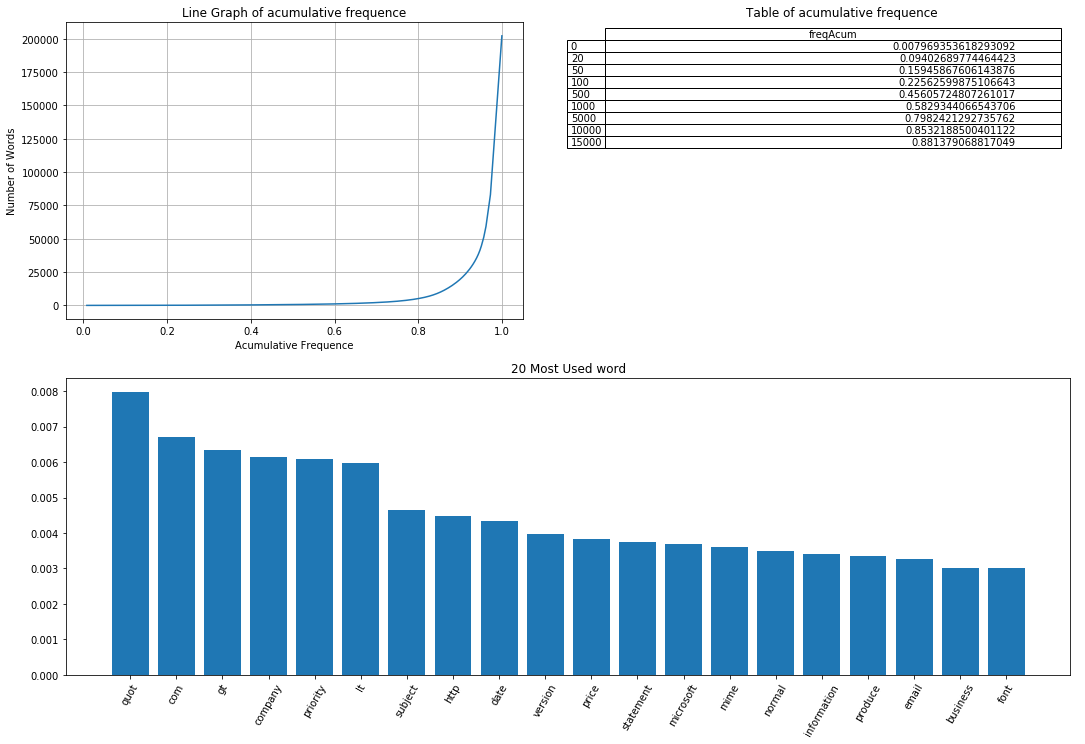

In [29]:
dfSpamWords = pd.DataFrame(list(dict(countSpam).items()))
dfSpamWords.columns = ['word', 'occur'] 
totalSpamOcurr = dfSpamWords['occur'].sum()
dfSpamWords['freq'] = dfSpamWords['occur'] / totalSpamOcurr  
dfSpamWords = dfSpamWords.sort_values(by='freq', ascending=False)
dfSpamWords = dfSpamWords.reset_index(drop=True)
dfSpamWords['freqAcum'] = dfSpamWords['freq'].cumsum()


fig = plt.figure(figsize = (18,12))
grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
pltLine = fig.add_subplot(grid[0:2,0])
pltBar = fig.add_subplot(grid[2:4,0:2])
pltTable = fig.add_subplot(grid[0:2,1])

pltLine.plot(dfSpamWords['freqAcum'], range(len(dfSpamWords)))
pltLine.set_ylabel('Number of Words')
pltLine.set_xlabel('Acumulative Frequence')
pltLine.set_title('Line Graph of acumulative frequence')
pltLine.grid(True)


dfSWord = dfSpamWords.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTable.table(cellText=dfSWord.values, rowLabels= dfSWord.index, colLabels = dfSWord.columns, loc='best')
pltTable.axis('off')
pltTable.set_title('Table of acumulative frequence')



pltBar.bar(dfSpamWords.head(20)['word'], dfSpamWords.head(20)['freq'], align='center')
pltBar.set_title('20 Most Used word')

yPos = np.arange(20)
pltBar.set_xticklabels(dfSpamWords.head(20)["word"], rotation=60)
pltBar.set_xticks(yPos)

plt.show()



### 20 Most common words on Ham emails

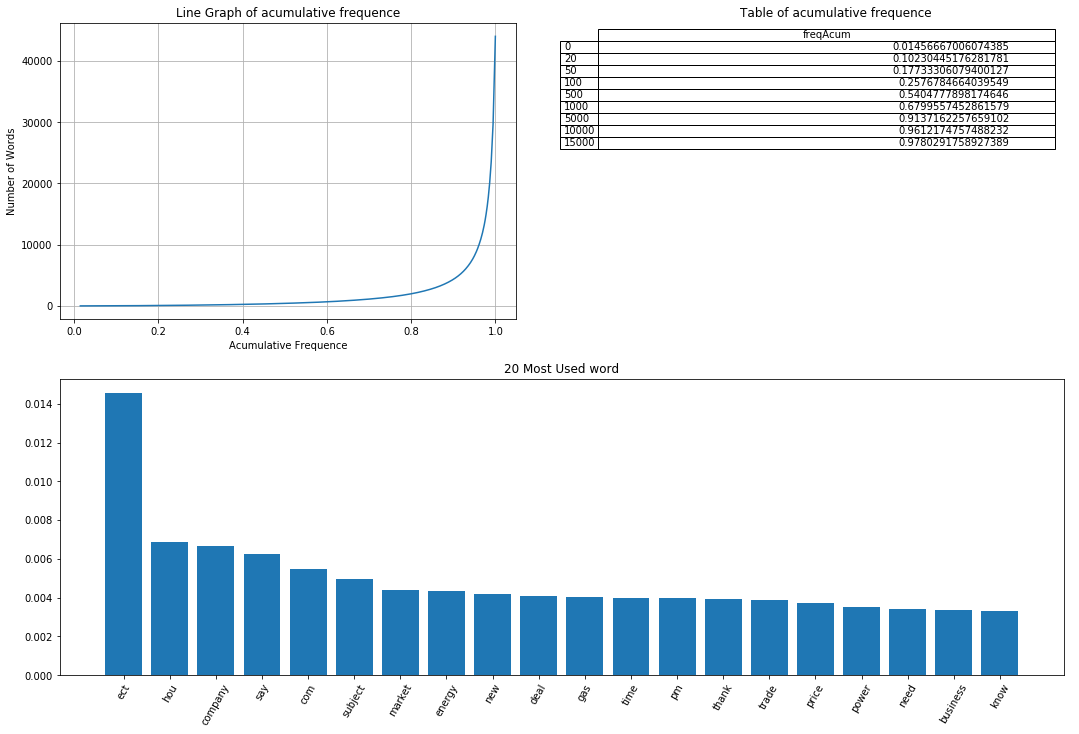

In [30]:
dfHamWords = pd.DataFrame(list(dict(countHam).items()))
dfHamWords.columns = ['word', 'occur'] 
totalHamOcurr = dfHamWords['occur'].sum()
dfHamWords['freq'] = dfHamWords['occur'] / totalHamOcurr  
dfHamWords = dfHamWords.sort_values(by='freq', ascending=False)
dfHamWords = dfHamWords.reset_index(drop=True)
dfHamWords['freqAcum'] = dfHamWords['freq'].cumsum()


fig = plt.figure(figsize = (18,12))
grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
pltLine = fig.add_subplot(grid[0:2,0])
pltBar = fig.add_subplot(grid[2:4,0:2])
pltTable = fig.add_subplot(grid[0:2,1])

pltLine.plot(dfHamWords['freqAcum'], range(len(dfHamWords)))
pltLine.set_ylabel('Number of Words')
pltLine.set_xlabel('Acumulative Frequence')
pltLine.set_title('Line Graph of acumulative frequence')
pltLine.grid(True)


dfHWord = dfHamWords.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTable.table(cellText=dfHWord.values, rowLabels= dfHWord.index, colLabels = dfHWord.columns, loc='best')
pltTable.axis('off')
pltTable.set_title('Table of acumulative frequence')



pltBar.bar(dfHamWords.head(20)['word'], dfHamWords.head(20)['freq'], align='center')
pltBar.set_title('20 Most Used word')

yPos = np.arange(20)
pltBar.set_xticklabels(dfHamWords.head(20)["word"], rotation=60)
pltBar.set_xticks(yPos)

plt.show()



## Calculate word frequence for subject

In [31]:
stopHere / 1

NameError: name 'stopHere' is not defined

## Calculate Word frequence for from email

In [ ]:
tempStr = 'a b c44 66d e5e '

clean = re.compile('[0-9]')
tex = re.sub(clean, " ", tempStr)

print(tex)



In [ ]:
tempSet = sorted(set(list(chain(*df[df['isSpam'] == True]["wordsList"].values))))


print(tempSet)

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(tempSet)

print(misspelled)

In [ ]:
lem = WordNetLemmatizer()
words = lem.lemmatize('accommodations')

words

## Modeling

### Spliting prepare data set for modeling 

In [ ]:
#print(text.ENGLISH_STOP_WORDS)

print(type(text.ENGLISH_STOP_WORDS))



In [ ]:
l = list(chain(*df["wordsList"].values))

l = set(filter(lambda k : len(k) == 1, l))

l

In [ ]:
dfWordsG = pd.DataFrame(list(dict(count).items()))
dfWordsG.columns = ['word', 'occur'] 
totalOcurrG = dfWordsG['occur'].sum()
dfWordsG['freq'] = dfWordsG['occur'] / totalOcurrG  
dfWordsG = dfWordsG.sort_values(by='freq', ascending=False)
dfWordsG = dfWordsG.reset_index(drop=True)
dfWordsG['freqAcum'] = dfWordsG['freq'].cumsum()

dfSpamWordsG = pd.DataFrame(list(dict(countSpam).items()))
dfSpamWordsG.columns = ['word', 'occur'] 
totalSpamOcurrG = dfSpamWordsG['occur'].sum()
dfSpamWordsG['freq'] = dfSpamWordsG['occur'] / totalOcurrG  
dfSpamWordsG = dfSpamWordsG.sort_values(by='freq', ascending=False)
dfSpamWordsG = dfSpamWordsG.reset_index(drop=True)
dfSpamWordsG['freqAcum'] = dfSpamWordsG['freq'].cumsum()

dfHamWordsG = pd.DataFrame(list(dict(countHam).items()))
dfHamWordsG.columns = ['word', 'occur'] 
totalHamOcurrG = dfHamWordsG['occur'].sum()
dfHamWordsG['freq'] = dfHamWordsG['occur'] / totalOcurrG  
dfHamWordsG = dfHamWordsG.sort_values(by='freq', ascending=False)
dfHamWordsG = dfHamWordsG.reset_index(drop=True)
dfHamWordsG['freqAcum'] = dfHamWordsG['freq'].cumsum()

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,3, wspace =0.2)
pltTotal = fig.add_subplot(grid[0,0])
pltSpam = fig.add_subplot(grid[0,1])
pltHam = fig.add_subplot(grid[0,2])

pltTotal.plot(dfWords['freqAcum'], range(len(dfWordsG)))
pltTotal.set_ylabel('Total Words')
pltTotal.set_xlabel('Acumulative Frequence')
pltTotal.set_title('All Words')
pltTotal.grid(True)

pltSpam.plot(dfSpamWords['freqAcum'], range(len(dfSpamWordsG)))
pltSpam.set_ylabel('Total Spam Words')
pltSpam.set_xlabel('Acumulative Frequence')
pltSpam.set_title('Spam Words')
pltSpam.grid(True)

pltHam.plot(dfHamWords['freqAcum'], range(len(dfHamWordsG)))
pltHam.set_ylabel('Total Ham Words')
pltHam.set_xlabel('Acumulative Frequence')
pltHam.set_title('Ham Words')
pltHam.grid(True)


fig2 = plt.figure(figsize = (18,6))
grid2 = plt.GridSpec(1,6, wspace =0.4)

pltTotalTableG = fig2.add_subplot(grid2[0,0:2])
pltSpamTableG = fig2.add_subplot(grid2[0,2:4])
pltHamTableG = fig2.add_subplot(grid2[0,4:6])

dfTWordG = dfWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTotalTableG.table(cellText=dfTWordG.values, rowLabels= dfTWordG.index, colLabels = dfTWordG.columns, loc='best')
pltTotalTableG.axis('off')

dfSWordG = dfSpamWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltSpamTableG.table(cellText=dfSWordG.values, rowLabels= dfSWordG.index, colLabels = dfSWordG.columns, loc='best')
pltSpamTableG.axis('off')

dfHWordG = dfHamWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltHamTableG.table(cellText=dfHWordG.values, rowLabels= dfHWordG.index, colLabels = dfHWordG.columns, loc='best')
pltHamTableG.axis('off')


plt.show()


In [ ]:
patternStop = re.compile(r'\b(' + r'|'.join(text.ENGLISH_STOP_WORDS) + r')\b\s*')
text = patternStop.sub(' ', text)



In [ ]:
t


In [ ]:
txt.ENGLISH_STOP_WORDS